In [1]:
%matplotlib inline

from __future__ import division
import numpy as np
from numpy.fft import fftshift
import menpo.io as mio
from menpo.math import log_gabor
from menpo.image import Image
from menpo.feature import ndfeature, greyscale, normalize_norm, normalize_std, fast_dsift
from menpo.landmark import labeller, ibug_face_66
from menpo.visualize import visualize_images, print_dynamic, progress_bar_str
from menpofit.visualize import visualize_fitting_results
from alaborticcv2015.alignment import LKFitter, FilteredSSD, FilteredFourierSSD, GradientCorrelation

# Multipie experiment: Other methods

In [2]:
folder_path = '/data/PhD/alaborticcv2015/'

In [3]:
images = []
for i in mio.import_images(folder_path + 'data/multipie/**/*', verbose=True):
    i.crop_to_landmarks_proportion_inplace(0.5)
    i = i.rescale_landmarks_to_diagonal_range(200)
    labeller(i, 'PTS', ibug_face_66)
    lms = i.landmarks['ibug_face_66'].lms
    bb = lms.bounding_box()
    i.landmarks['bounding_box'] = bb
    images.append(i)

- Loading 100 assets: [====================] 100%

In [4]:
n_subjects = 5
n_images_subject = 20

subjects = []
for j in range(n_subjects):
    subject = {'template':images[j*n_images_subject+7],
               'test_images':images[j*n_images_subject:j*n_images_subject+n_images_subject]}
    subjects.append(subject)

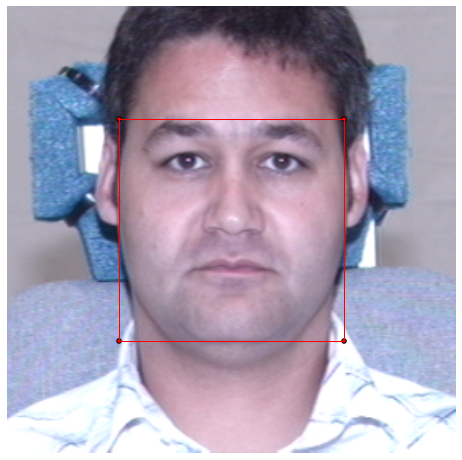

In [5]:
templates = [subject['template'] for subject in subjects]
visualize_images(templates)

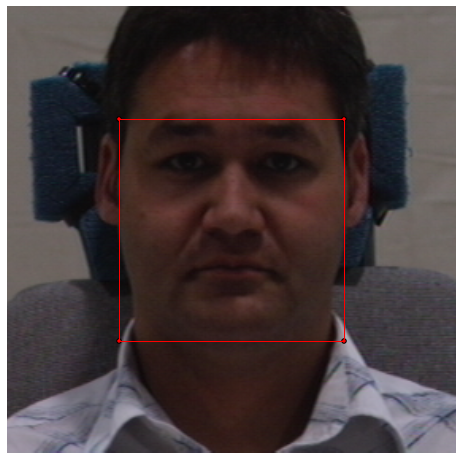

In [6]:
test_images = []
for subject in subjects:
    test_images += subject['test_images']
visualize_images(test_images)

In [7]:
features = greyscale
diagonal = 100
scales = (1,)
max_iters = 50
noise_std = 10
n_rep = 10

# LogGabor

In [8]:
# define kernel function
def kernel_func(ext_shape):
    return fftshift(log_gabor(np.ones(ext_shape))[2])

results = []
errors = np.empty((n_subjects, n_images_subject, n_rep, max_iters+len(scales)))

# for all subjects
for sub, subject in enumerate(subjects):
    
    template = subject['template']
    test_images = subject['test_images']

    string = ' - loggabor, subject: {} '.format(sub)
    
    # create LK fitter
    fitter = LKFitter(template,
                      group='bounding_box',
                      features=features,
                      diagonal=diagonal,
                      scales=scales,
                      residual_cls=FilteredFourierSSD,
                      kernel_func = kernel_func,
                      eps=-1)


    # random seed
    np.random.seed(seed=0)

    # for all images
    fitter_results = []
    for j, i in enumerate(test_images):
        string2 = string + ' image {}: '.format(j)

        # for each repetition
        frs = []
        for k in range(n_rep):

            # fit image
            gt_s = i.landmarks['bounding_box'].lms
            s = fitter.perturb_shape(gt_s, noise_std=noise_std)
            fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=max_iters)

            # save fitter result
            fr = fr.as_serializableresult()
            frs.append(fr)

            # compute error
            errors[sub, j, k] = fr.errors() 

        # save each repetition fitting result
        fitter_results.append(frs)

        # compute and print errors statistics per image
        ini_errors = errors[sub, j, :, 0]
        ini_mean = np.mean(ini_errors)
        ini_median = np.median(ini_errors)
        ini_std = np.std(ini_errors)
        final_errors = errors[sub, j, :, -1]
        final_mean = np.mean(final_errors)
        final_median = np.median(final_errors)
        final_std = np.std(final_errors)
        print_dynamic(string2 + 
                      '\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                      ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                      ' std: {0:.4f} - {1:.4f} '.format(ini_std, final_std))

    # compute and print error statistics per network
    ini_errors = errors[sub, :, :, 0]
    ini_mean = np.mean(ini_errors)
    ini_median = np.median(ini_errors)
    ini_std = np.std(ini_errors)
    final_errors = errors[sub, :, :, -1]
    final_mean = np.mean(final_errors)
    final_median = np.median(final_errors)
    final_std = np.std(final_errors)
    print_dynamic(string +
                  '\t\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                  ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                  ' std: {0:.4f} - {1:.4f} \n'.format(ini_std, final_std))
    
    # save each image fitting result
    results.append(fitter_results)
    
# save network fitting results
file_name = (folder_path
             + 'results/multipie/multipie_loggabor' 
             + '.pkl.gz') 
mio.export_pickle(results, file_name, overwrite=True)

 - loggabor, subject: 0 		mean: 0.0758 - 0.0670  median: 0.0739 - 0.0192  std: 0.0223 - 0.0854 
 - loggabor, subject: 1 		mean: 0.0758 - 0.0492  median: 0.0739 - 0.0165  std: 0.0223 - 0.0705 
 - loggabor, subject: 2 		mean: 0.0758 - 0.0312  median: 0.0739 - 0.0142  std: 0.0223 - 0.0527 
 - loggabor, subject: 3 		mean: 0.0758 - 0.0493  median: 0.0739 - 0.0295  std: 0.0224 - 0.0521 
 - loggabor, subject: 4 		mean: 0.0759 - 0.0421  median: 0.0740 - 0.0332  std: 0.0224 - 0.0370 


/data/pythondev/src/menpo/menpo/image/base.py:130: UserWarning: The copy flag was NOT honoured. A copy HAS been made. Please ensure the data you pass is C-contiguous.
  warn('The copy flag was NOT honoured. A copy HAS been made. '


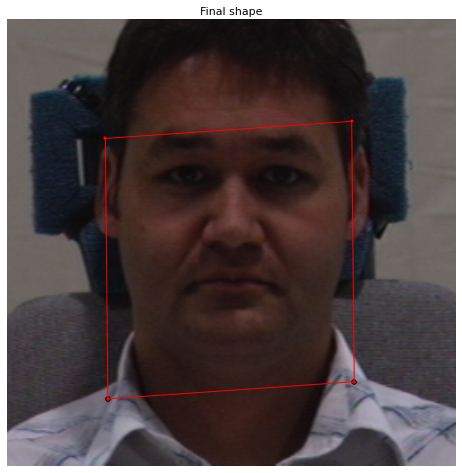

In [9]:
# undo list nesting
fitter_results = [fr for fitting_results in results for frs in fitting_results for fr in frs]

# visualize
visualize_fitting_results(fitter_results)

# Gradient Correlation

In [10]:
results = []
errors = np.empty((n_subjects, n_images_subject, n_rep, max_iters+len(scales)))

# for all subjects
for sub, subject in enumerate(subjects):
    
    template = subject['template']
    test_images = subject['test_images']

    string = ' - gradcorr, subject: {} '.format(sub)
    
    # create LK fitter
    fitter = LKFitter(template,
                      group='bounding_box',
                      features=features,
                      diagonal=diagonal,
                      scales=scales,
                      residual_cls=GradientCorrelation,
                      eps=-1)


    # random seed
    np.random.seed(seed=0)

    # for all images
    fitter_results = []
    for j, i in enumerate(test_images):
        string2 = string + ' image {}: '.format(j)

        # for each repetition
        frs = []
        for k in range(n_rep):

            # fit image
            gt_s = i.landmarks['bounding_box'].lms
            s = fitter.perturb_shape(gt_s, noise_std=noise_std)
            fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=max_iters)

            # save fitter result
            fr = fr.as_serializableresult()
            frs.append(fr)

            # compute error
            errors[sub, j, k] = fr.errors() 

        # save each repetition fitting result
        fitter_results.append(frs)

        # compute and print errors statistics per image
        ini_errors = errors[sub, j, :, 0]
        ini_mean = np.mean(ini_errors)
        ini_median = np.median(ini_errors)
        ini_std = np.std(ini_errors)
        final_errors = errors[sub, j, :, -1]
        final_mean = np.mean(final_errors)
        final_median = np.median(final_errors)
        final_std = np.std(final_errors)
        print_dynamic(string2 + 
                      '\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                      ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                      ' std: {0:.4f} - {1:.4f} '.format(ini_std, final_std))

    # compute and print error statistics per network
    ini_errors = errors[sub, :, :, 0]
    ini_mean = np.mean(ini_errors)
    ini_median = np.median(ini_errors)
    ini_std = np.std(ini_errors)
    final_errors = errors[sub, :, :, -1]
    final_mean = np.mean(final_errors)
    final_median = np.median(final_errors)
    final_std = np.std(final_errors)
    print_dynamic(string +
                  '\t\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                  ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                  ' std: {0:.4f} - {1:.4f} \n'.format(ini_std, final_std))
    
    # save each image fitting result
    results.append(fitter_results)
    
# save network fitting results
file_name = (folder_path
             + 'results/multipie/multipie_gradientcorrelation' 
             + '.pkl.gz') 
mio.export_pickle(results, file_name, overwrite=True)

 - gradcorr, subject: 0 		mean: 0.0758 - 0.0508  median: 0.0739 - 0.0220  std: 0.0223 - 0.0890 
 - gradcorr, subject: 1 		mean: 0.0758 - 0.0571  median: 0.0739 - 0.0070  std: 0.0223 - 0.4950 
 - gradcorr, subject: 2 		mean: 0.0758 - 0.0547  median: 0.0739 - 0.0082  std: 0.0223 - 0.2107 
 - gradcorr, subject: 3 		mean: 0.0758 - 0.0455  median: 0.0739 - 0.0063  std: 0.0224 - 0.0833 
 - gradcorr, subject: 4 		mean: 0.0759 - 0.0332  median: 0.0740 - 0.0110  std: 0.0224 - 0.0449 


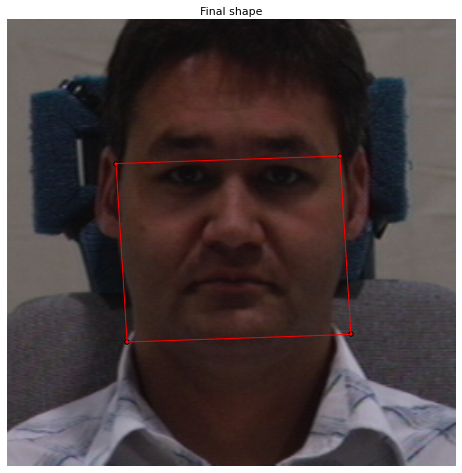

In [11]:
# undo list nesting
fitter_results = [fr for fitting_results in results for frs in fitting_results for fr in frs]

# visualize
visualize_fitting_results(fitter_results)

# dSift

In [12]:
@ndfeature
def dsift(pixels):
    return fast_dsift(pixels)

results = []
errors = np.empty((n_subjects, n_images_subject, n_rep, max_iters+len(scales)))

# for all subjects
for sub, subject in enumerate(subjects):
    
    template = subject['template']
    test_images = subject['test_images']

    string = ' - dsift, subject: {} '.format(sub)
    
    # create LK fitter
    fitter = LKFitter(template,
                      group='bounding_box',
                      features=dsift,
                      diagonal=diagonal,
                      scales=scales,
                      residual_cls=FilteredSSD,
                      eps=-1)


    # random seed
    np.random.seed(seed=0)

    # for all images
    fitter_results = []
    for j, i in enumerate(test_images):
        string2 = string + ' image {}: '.format(j)

        # for each repetition
        frs = []
        for k in range(n_rep):

            # fit image
            gt_s = i.landmarks['bounding_box'].lms
            s = fitter.perturb_shape(gt_s, noise_std=noise_std)
            fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=max_iters)

            # save fitter result
            fr = fr.as_serializableresult()
            frs.append(fr)

            # compute error
            errors[sub, j, k] = fr.errors() 

        # save each repetition fitting result
        fitter_results.append(frs)

        # compute and print errors statistics per image
        ini_errors = errors[sub, j, :, 0]
        ini_mean = np.mean(ini_errors)
        ini_median = np.median(ini_errors)
        ini_std = np.std(ini_errors)
        final_errors = errors[sub, j, :, -1]
        final_mean = np.mean(final_errors)
        final_median = np.median(final_errors)
        final_std = np.std(final_errors)
        print_dynamic(string2 + 
                      '\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                      ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                      ' std: {0:.4f} - {1:.4f} '.format(ini_std, final_std))

    # compute and print error statistics per network
    ini_errors = errors[sub, :, :, 0]
    ini_mean = np.mean(ini_errors)
    ini_median = np.median(ini_errors)
    ini_std = np.std(ini_errors)
    final_errors = errors[sub, :, :, -1]
    final_mean = np.mean(final_errors)
    final_median = np.median(final_errors)
    final_std = np.std(final_errors)
    print_dynamic(string +
                  '\t\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                  ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                  ' std: {0:.4f} - {1:.4f} \n'.format(ini_std, final_std))
    
    # save each image fitting result
    results.append(fitter_results)
    
# save network fitting results
file_name = (folder_path
             + 'results/multipie/multipie_dsift' 
             + '.pkl.gz') 
mio.export_pickle(results, file_name, overwrite=True)

 - dsift, subject: 0 		mean: 0.0758 - 0.0263  median: 0.0739 - 0.0242  std: 0.0223 - 0.0164 
 - dsift, subject: 1 		mean: 0.0758 - 0.0132  median: 0.0739 - 0.0116  std: 0.0223 - 0.0104 
 - dsift, subject: 2 		mean: 0.0758 - 0.0167  median: 0.0739 - 0.0163  std: 0.0223 - 0.0107 
 - dsift, subject: 3 		mean: 0.0758 - 0.0211  median: 0.0739 - 0.0154  std: 0.0224 - 0.0221 
 - dsift, subject: 4 		mean: 0.0759 - 0.0372  median: 0.0740 - 0.0289  std: 0.0224 - 0.0307 


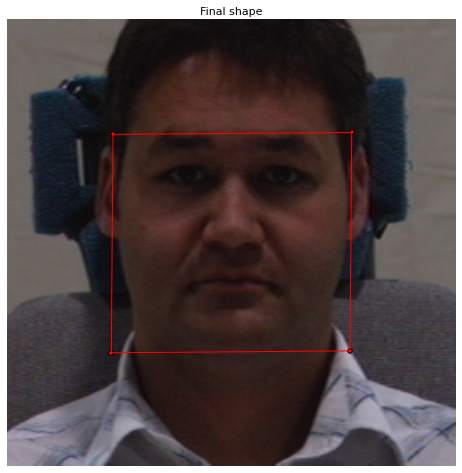

In [13]:
# undo list nesting
fitter_results = [fr for fitting_results in results for frs in fitting_results for fr in frs]

# visualize
visualize_fitting_results(fitter_results)